In [1]:
import os
import subprocess
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from scipy.stats import linregress
import math
from datetime import datetime
import dill
import seaborn as sns
import statistics
import sys
import numpy as np
import math
import os
import subprocess
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from scipy.stats import linregress
import math
from datetime import datetime
import dill
import seaborn as sns
from sklearn.metrics import mutual_info_score
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator
import ipyparallel as ipp

def getDistanceV2(X,d,lag,point1,point2):
    summary = 0
    for i in range(0,d*lag+1,lag):
        summary += (X[point1 + i] - X[point2 + i])**2
    summary = math.sqrt(summary)
    return summary

def simplex_projection(data,d,lag,prediction_steps,neighbor_numbers):
    # data is 1D scalar temporal
    neighbors_distance = []
    neighbors_index = []
    
    for ii,i in enumerate(range(int(len(data) / 2), len(data) - 1 - d * lag  - prediction_steps)):
        neighbors_distance.append(np.full(neighbor_numbers,1e10))
        neighbors_index.append(np.zeros(neighbor_numbers))
        for j in range(int(len(data) / 2) - 1 - d * lag  - prediction_steps):
            distance = getDistanceV2(data,d,lag,i,j)
            if distance < max(neighbors_distance[ii]):
                max_index = np.argmax(neighbors_distance[ii])
                neighbors_distance[ii][max_index] = distance
                neighbors_index[ii][max_index] = j
    
    prediction = []
    observation = []
    
    for step in range(prediction_steps):
        observation.append([])
        prediction.append([])
        for ii,i in enumerate(range(int(len(data) / 2), len(data) - 1 - d * lag  - prediction_steps)):
            observation[step].append(data[int(i + d*lag + step + 1)])
            cur_prediction = 0
            total_weight = 0
            
            for neighbor in neighbors_index[ii]:
                cur_prediction += (1 / getDistanceV2(data,d,lag,i,j)) * data[int(neighbor + d*lag + step + 1)]
                total_weight += (1 / getDistanceV2(data,d,lag,i,j))
                
            cur_prediction /= total_weight
            prediction[step].append(cur_prediction)
    return prediction,observation
def avg(lya):
    result = []
    err = []
    
    for j in range(len(lya[0][0])):
        result.append([])
        err.append([])
        value = []      
        for i in range(len(lya)):
            if lya[i][0][j]!= float("inf"):
                value.append(lya[i][0][j])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err

def avg_repeat(lya):
    result = []
    err = []
    
    for j in range(len(lya[0][0])):
        result.append([])
        err.append([])
        value = []   
        for k in range(len(lya)):
            for i in range(len(lya[0])):
                if lya[k][i][j][0]!= float("inf"):
                    value.append(lya[k][i][j][0])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err

def avg_repeat2(lya):
    result = []
    err = []
    
    for j in range(len(lya[0][0][0])):
        result.append([])
        err.append([])
        value = []   
        for k in range(len(lya)):
            for i in range(len(lya[0])):
                if lya[k][i][0][j]!= float("inf"):
                    value.append(lya[k][i][0][j])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err

def avg_taupw(lya):
    result = []
    err = []
    
    for j in range(len(lya[0])):
        result.append([])
        err.append([])
        value = []      
        for i in range(len(lya)):
            if lya[i][j][0]!= float("inf"):
                value.append(lya[i][j][0])

        result[j] = sum(value)/len(value)
        err[j] = np.std(value)       
    return result,err
def linear_interpolation(y0,y1,x0,x1,x):
    
    return (y0 * (x1-x) + y1 * (x-x0)) / (x1-x0)
def get_APD_and_voltage_new(path,threshhold,dt):
    
    number_of_points = 0
    end_of_first_dt = False
    data = []
    
    with open(path) as csv_file: # totally 501 points
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        for row in csv_reader:
            for i in range(len(row)):
                for j in row[i]:
                    if j == ';':
                        row[i] = row[i].replace(';', '')
                        if end_of_first_dt == False:
                            end_of_first_dt = True
                            number_of_points = i
                if row[i] != '':           
                    data.append(float(row[i]))                
    if (len(data)/number_of_points).is_integer():
        rows, cols=number_of_points,int(len(data)/number_of_points)
    else:
        print('error! non-integar time steps')     

    voltage = np.zeros([rows,cols])

    for i in range(rows):
        for j in range(cols):

            voltage[i][j] = data[j * rows +  i]
         
    APD = []
    # linear interpolation 
    APD_start_error = -100
    APD_end_error = -100    


    for i in range(number_of_points):
        APD.append([])
        
        APD_value = 0
        start_apd = False
        
        for j in range(len(voltage[0])):


            if j != 0 and start_apd == False and voltage[i][j] > threshhold   and j+1 < len(voltage[0]) and voltage[i][j+1] > threshhold:
                start_apd = True
                APD_start_error = linear_interpolation(1,0,voltage[i][j],voltage[i][j-1],threshhold)
                APD_start_error = 1 - APD_start_error

            if start_apd == True and voltage[i][j] <= threshhold and j+1 < len(voltage[0]) and voltage[i][j+1] <= threshhold: 
                start_apd = False
                APD_end_error = linear_interpolation(0,-1,voltage[i][j],voltage[i][j-1],threshhold)
                
                # linear interpolation 
                APD_value += (APD_start_error + APD_end_error) * dt
 
                
                APD[i].append(APD_value)
            
                APD_value = 0
                APD_start_error = -100
                APD_end_error = -100 
                
            if start_apd == True:
                APD_value += dt
        
        # trim first incomplete APD
        if voltage[i][1] > threshhold and voltage[i][2] > threshhold:
            APD[i].pop(0)
    
    return APD,voltage
def get_APD_and_voltage_uvw(path,threshhold,dt,scale = False):
    
    number_of_points = 0
    end_of_first_dt = False
    
    data = []
    with open(path) as csv_file: # totally 501 points
        csv_reader = csv.reader(csv_file, delimiter=',')
        
        for row in csv_reader:
            for i in range(len(row)):
                for j in row[i]:
                    if j == ';':
                        row[i] = row[i].replace(';', '')
                        if end_of_first_dt == False:
                            end_of_first_dt = True
                            number_of_points = i
                        
                if row[i] != '' and i%4 != 0: 
                    data.append(float(row[i]))    
    max_value = max(data)
    min_value = min(data)
    if scale == True:
        for i in range(len(data)):
            data[i] = (data[i] - min_value) / (max_value - min_value)

    # if we input whole texture
    if (number_of_points * 3 / 4).is_integer():
        number_of_points = int( number_of_points * 3 / 4)
    else:
        print('error! non-integar number of points')
    # if we input whole texture
    
    if (len(data)/number_of_points).is_integer():
        rows, cols=number_of_points,int(len(data)/number_of_points)
    else:
        print('error! non-integar time steps',len(data),number_of_points) 
        
    voltage = np.zeros([rows,cols])

    for i in range(rows):
        for j in range(cols):

            voltage[i][j] = data[j * rows +  i]

    print(number_of_points)
    
    APD = []
    # linear interpolation 
    APD_start_error = -100
    APD_end_error = -100    


    for i in range(number_of_points):
        APD.append([])
        
        APD_value = 0
        start_apd = False

        if i % 3 != 2 :
        
            for j in range(len(voltage[0])):
    
    
                if j != 0 and start_apd == False and voltage[i][j] > threshhold   and j+1 < len(voltage[0]) and voltage[i][j+1] > threshhold:
                    start_apd = True
                    
                    if j%4 == 0 and abs(voltage[i][j] - voltage[i][j-1]) < 1e-9:
                        print(i,j)
                        print( voltage[i])
                        sys.exit()
                    APD_start_error = linear_interpolation(1,0,voltage[i][j],voltage[i][j-1],threshhold)
                    APD_start_error = 1 - APD_start_error
    
                if start_apd == True and voltage[i][j] < threshhold and j+1 < len(voltage[0]) and voltage[i][j+1] < threshhold: 
                    start_apd = False
                    APD_end_error = linear_interpolation(0,-1,voltage[i][j],voltage[i][j-1],threshhold)
                    
                    # linear interpolation 
                    APD_value += (APD_start_error + APD_end_error) * dt
     
                    
                    APD[i].append(APD_value)
                
                    APD_value = 0
                    APD_start_error = -100
                    APD_end_error = -100 
                    
                if start_apd == True:
                    APD_value += dt
            
            # trim first incomplete APD
            if voltage[i][1] > threshhold and voltage[i][2] > threshhold and len(APD[i]) > 0:
                APD[i].pop(0)
            
    APD_u = []
    APD_v = []
    #APD_w = []
    voltage_u = []
    voltage_v = []
    voltage_w = []

    for i in range(len(APD)):
        if (i+1) % 3 == 1:
            APD_u.append(APD[i])
            voltage_u.append(voltage[i])
        if (i+1) % 3 == 2:
            APD_v.append(APD[i])
            voltage_v.append(voltage[i])
        if (i+1) % 3 == 0:
            #APD_w.append(APD[i])
            voltage_w.append(voltage[i])

    APD_uvw = [APD_u,APD_v]#,APD_w]
    voltage_uvw = [voltage_u,voltage_v,voltage_w]
    
    return APD_uvw,voltage_uvw
    



def embed_data(data,m,tau=1):
    
    embedded_data = np.zeros([len(data) - m*tau,m])
    
    for i in range(len(data) - m*tau):
        for j in range(m):
            embedded_data[i][j] = data[i + j*tau]
    return embedded_data


def euclidian_distance(X,Y):
    dis = 0
    for i in range(len(X)):
        dis += (X[i] - Y[i])**2
    return np.sqrt(dis)

def magnitude(X): 
    magnitude = 0
    for i in range(len(X)):
        magnitude += X[i]**2
    return np.sqrt(magnitude)

def angle(X,Y):
    
    return math.acos(round( np.dot(X, Y) / ( magnitude(X) * magnitude(Y) )  , 7) )

def find_nearest_neighbor(embedded_data,cur_point,epsilon,theta,boundary):
    
    length = len(embedded_data)
    dim = len(embedded_data[0])
    
    dis = 1e8
    nearest_Y_index = 1e8
    X = embedded_data[cur_point]
    
    for i in range(int(length - boundary)):
        Y = embedded_data[i]
        if i != cur_point and euclidian_distance(X,Y) < dis and angle(X,Y) < theta:
            dis = euclidian_distance(X,Y)
            nearest_Y_index = i
    
    if dis < epsilon:
        return dis,nearest_Y_index
    else:
        print("cannot find neighbor for point ", cur_point, ',dis = ', dis)
        return False
    
def find_L_and_evolve_point(embedded_data,cur_point,epsilon,theta,boundary):
    
    L0 = 0
    L0_prime = 0
    
    length = len(embedded_data)
    dim = len(embedded_data[0])
    
    x = embedded_data[cur_point]
    
    result = find_nearest_neighbor(embedded_data,cur_point,epsilon,theta,boundary)
    
    while result == False:
        return False

    
    neighbor_point = result[1]
    z = embedded_data[neighbor_point]

    
    L0 =  result[0]
    L0_prime = result[0]
    
    step = 0
    while L0_prime < epsilon and (cur_point + step) < length and (neighbor_point + step) < length:

        
        '''
        if cur_point + step >= length:
            if cur_point < (3/4 * length):
                print("cur_point + step >= length",embedded_data[cur_point + step] , embedded_data[neighbor_point + step],cur_point )
            return False
        '''
        x = embedded_data[cur_point + step]
        '''
        if neighbor_point + step >= length:
            print("neighbor_point + step >= length",embedded_data[cur_point + step] , embedded_data[neighbor_point + step],neighbor_point )
            return False
        '''
        z = embedded_data[neighbor_point + step]
        
        L0_prime = euclidian_distance(x,z)
        step += 1
        
    return np.log(L0_prime / L0) / np.log(2) , cur_point + step

    
def wolf_lya_exp(embedded_data,epsilon = 0.1,start_point = 'middle',theta = np.pi / 9,boundary = 1500):
    
    if start_point == 'middle':
        start_point = int(len(embedded_data) / 2) - boundary
    
    cur_point = start_point
    log_sum = 0
    
    while cur_point < len(embedded_data):
        
        result = find_L_and_evolve_point(embedded_data,cur_point,epsilon,theta,boundary)

        if result != False:     
            log_sum += result[0]
            cur_point = result[1]        
        
        if cur_point == start_point:
            start_point += 1
            cur_point = start_point           
            continue
        
        if result == False:
            break

        

    return log_sum /  (cur_point - start_point)


#dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

def run_cmd(command): # cmd /k command
    
    
    
    command ='cmd /k \"' +  command + '\"'

    try:
        os.system(command)
        result = subprocess.check_output(command, shell=True, text=True)
        #print(result)        
        
    except:
        print('error os cmd')
        
def getDistance(X,i,d,k,h):
    summary = 0
    for j in range(i-1,i+d-1):
        summary += (X[j][k] - X[j][h])**2
    summary = math.sqrt(summary)
    return summary
def findPairs(X,i,d,k,h,e):
    if k == h:
        return False
    summary = getDistance(X,i,d,k,h)
    if summary < e and summary > 0:
        #print(summary)
        return True
    else:
        return False
def findLyp(X,d,e):
    lyp = 0
    Np = 0
    m = X.shape[0]
    L = X.shape[1]
    for jj in range(0,m-d):
        #print(jj)
        for kk in range(L):
            for hh in range(kk + 1,L):
                if findPairs(X,jj+1,d,kk,hh,e) == True and getDistance(X,jj+2,d,kk,hh) > 0:
                    Np += 1
                    lyp += math.log(getDistance(X,jj+2,d,kk,hh)/getDistance(X,jj+1,d,kk,hh))
                    #if (abs(lyp) > 1000):
                        #print(lyp,getDistance(jj+2,d,kk,hh),getDistance(jj+1,d,kk,hh),jj,kk,hh)

    if Np == 0:
        print('error')
        return
    lyp = lyp/Np
    #print("lyapunov exp is:",lyp,"\nnumber of pairs found:",Np)
    return lyp

def linear_interpolation(y0,y1,x0,x1,x):
    return (y0 * (x1-x) + y1 * (x-x0)) / (x1-x0)

def get_APD_and_voltage(tau_pw,tau_d,number_of_points,dt = 4,noise = False, noise_value_percentage = 0.1):
    
    tau_pw = str(tau_pw)
    tau_d = str(tau_d)
    data = []

    with open('tau_pw_' + tau_pw + '_tau_d_' + tau_d + '_spatial.csv') as csv_file: # totally 501 points
        csv_reader = csv.reader(csv_file, delimiter='.')
        for row in csv_reader:
            data.append(float(row[0] + '.' + row[1][:-1]))
            for i in range(1,len(row) - 1):
                for j in row[i + 1]:
                    if j == ';':
                        row[i + 1] = row[i + 1].replace(';', '')
                        
                if i == len(row) - 2:    
                    data.append(float(row[i][-1] + '.' + row[i + 1][:]))                    
                
                else:
                    data.append(float(row[i][-1] + '.' + row[i + 1][:-1]))
                    #r_03999.append(float(row[i]))                
    
    rows, cols=number_of_points,int(len(data)/number_of_points)
    voltage = np.zeros([rows,cols])

    for i in range(rows):
        for j in range(cols):

            voltage[i][j] = data[j * rows +  i]
         
    APD = []
    # linear interpolation 
    APD_start_error = -100
    APD_end_error = -100    


    for i in range(number_of_points):
        APD.append([])
        
        APD_value = 0
        start_apd = False
        
        for j in range(len(voltage[0])):


            if j != 0 and start_apd == False and voltage[i][j] > 0.3   and j+1 < len(voltage[0]) and voltage[i][j+1] > 0.3:
                start_apd = True
                APD_start_error = linear_interpolation(1,0,voltage[i][j],voltage[i][j-1],0.3)
                APD_start_error = 1 - APD_start_error

            if start_apd == True and voltage[i][j] <= 0.3 and j+1 < len(voltage[0]) and voltage[i][j+1] <= 0.3: 
                start_apd = False
                APD_end_error = linear_interpolation(0,-1,voltage[i][j],voltage[i][j-1],0.3)
                
                # linear interpolation 
                APD_value += (APD_start_error + APD_end_error) * dt
 
                
                APD[i].append(APD_value)
            
                APD_value = 0
                APD_start_error = -100
                APD_end_error = -100 
                
            if start_apd == True:
                APD_value += dt
        
        # trim first incomplete APD
        if voltage[i][1] > 0.3 and voltage[i][2] > 0.3:
            APD[i].pop(0)

        # add some percentage noise to APD data
        if noise == True:
            APD_averaged_for_i = sum(APD[i]) / len(APD[i])
            for APD_index_i in range(len(APD[i])):
                APD[i][APD_index_i] += 2 * np.round(random.uniform(-APD_averaged_for_i * noise_value_percentage, APD_averaged_for_i * noise_value_percentage) / 2)
                if APD[i][APD_index_i] < 0:
                    print("noise too large",APD[i][APD_index_i])
                    APD[i][APD_index_i] = 0
    
    return APD,voltage

def find_temp_lya_exp_growth_in_lyap_file(file_name,tisean_parameter):
    
    delta_s = []

        
    with open(file_name) as csv_file:
        csv_reader = csv.reader(csv_file)
        cur_eps_dim = False        
        for row in csv_reader:
            if row == [tisean_parameter]:
                cur_eps_dim = True
                continue
            
            if cur_eps_dim == True:
                
                if row == []:
                    break


                num = ''
                check_time = 0
                for i in row[0]:
                    if i == ' ':
                        check_time += 1
                        continue
                    if check_time == 1:
                        num += i
                num = float(num)
                delta_s.append(num) 
            else:
                continue
    return delta_s

def is_monotonic(arr):
    unique_elements = set(arr)
    increasing = sorted(arr) == arr or sorted(arr, reverse=True) == arr
    return increasing


def get_temporal_lya_exp(APD,how_many_temporal_lya_want,tau_pw,tau_d,r = 10, R = 50,s = 50,tisean_parameter = '#epsilon= 5.000000e+001  dim= 4',path = "D://Downloads/TISEAN_9_17"):
    
    tau_pw = str(tau_pw)
    tau_d = str(tau_d)
    
    temporal_lya_exp_list = [] # (lya exp)
    temporal_lya_exp_list_index = []
    


    point_index = list(range(len(APD)))

    random.shuffle(point_index)
    
    os.chdir(path)
    
    for i in point_index:

        # output the APD to dat file
        name = 'tau_pw_' + tau_pw + '_tau_d_' + tau_d + "_p" + str(i) + ".dat"
        f=open(name,"w")
        for line in APD[i]:
            f.write(str(line)+"\n")
        f.close()              


        # run tisean
        
        #if os.path.isfile(name + ".lyap") != True:
        
        command = 'lyap_k ' + name + ' -M4 -m3 -d1 -s' + str(s) + ' -r' + str(r) + ' -R' + str(R) +' -o'
        run_cmd(command)

        # examine if we have linear region for this point
        delta_s = find_temp_lya_exp_growth_in_lyap_file(name + ".lyap" , tisean_parameter)
        if delta_s != []:
            for linear_x_range in range(7,4,-1):
                if (is_monotonic(delta_s[:linear_x_range]) == True):
                    if delta_s[linear_x_range-1] > delta_s[0]:
                        if abs(min(delta_s[linear_x_range-1:]) - delta_s[linear_x_range-1]) < 0.1:
                            time = list(range(len(delta_s)))  

                            temporal_lya_exp_list.append(linregress(time[:linear_x_range],delta_s[:linear_x_range])[0])
                            temporal_lya_exp_list_index.append(i)
                          
                            break
        
                    elif delta_s[linear_x_range-1] < delta_s[0]:
                        if abs(max(delta_s[linear_x_range-1:]) - delta_s[linear_x_range-1]) < 0.1:
                            time = list(range(len(delta_s)))  

                            temporal_lya_exp_list.append(linregress(time[:linear_x_range],delta_s[:linear_x_range])[0])
                            temporal_lya_exp_list_index.append(i)  

                            break
                
                if len(temporal_lya_exp_list) >= how_many_temporal_lya_want:
                    return temporal_lya_exp_list,temporal_lya_exp_list_index            
                        
    return temporal_lya_exp_list,temporal_lya_exp_list_index 

def get_spatial_lya_exp(APD,number_of_points_used,spatial_dim = 4,spatial_diff = 3,repeat_time = 10):
    
    lyp_exp_list = []
    
    for repeat_time_i in range(repeat_time):
    
        shuffled_partial_APD = random.sample(APD, number_of_points_used)


        length = number_of_points_used

        min_minn = 3

        minn = 1e5
        for i in range(number_of_points_used):
            if len(shuffled_partial_APD[i]) < minn and len(shuffled_partial_APD[i]) > min_minn:
                minn = len(shuffled_partial_APD[i]) 
            if len(shuffled_partial_APD[i]) <= min_minn:
                length -= 1
                #print('zero apd detected')


        APD_consist = np.full((minn-1,length),-100) # [1:14]
        for i in range(length):
            for j in range(minn-1):
                if len(shuffled_partial_APD[i]) > min_minn:
                    APD_consist[j][i] = shuffled_partial_APD[i][j+1]
        lyp_exp = findLyp(APD_consist,spatial_dim,spatial_diff)     #  # taud = 0.41 
        
        if lyp_exp is not None:
            lyp_exp_list.append(lyp_exp)

        #print(lyp_exp,'minn',minn,'length',length,repeat_time_i,'\n')
    
    lyp_exp_averaged = sum(lyp_exp_list) / len(lyp_exp_list)      
    
    return lyp_exp_averaged,lyp_exp_list

#计算GP算法的嵌入维数(假近邻算法)
def get_m(imf, tau):
    N=len(imf)
    if (len(imf) != N):
        print('请输入指定的数据长度！')  # N为指定数据长度
        return 0, 0
    elif (isinstance(imf, np.ndarray) != True):
        print('数据格式错误！')
        return 0, 0
    else:
        m_max = 10
        P_m_all = []  # m_max-1个假近邻点百分率
        for m in range(1, m_max + 1):
            print(m)
            
            i_num = N - (m - 1) * tau
            kj_m = np.zeros((i_num, m))  # m维重构相空间
            for i in range(i_num):
                for j in range(m):
                    kj_m[i][j] = imf[i + j * tau]
            if (m > 1):
                index = np.argsort(Dist_m)
                a_m = 0  # 最近邻点数
                for i in range(i_num):
                    temp = 0
                    for h in range(i_num):
                        temp = index[i][h]
                        if (Dist_m[i][temp] > 0):
                            break
                    D = np.linalg.norm(kj_m[i] - kj_m[temp])
                    D = np.sqrt((D * D) / (Dist_m[i][temp] * Dist_m[i][temp]) - 1)
                    if (D > 10):
                        a_m += 1
                P_m_all.append(a_m / i_num)
            i_num_m = i_num - tau
            Dist_m = np.zeros((i_num_m, i_num_m))  # 两向量之间的距离
            for i in range(i_num_m):
                for k in range(i_num_m):
                    Dist_m[i][k] = np.linalg.norm(kj_m[i] - kj_m[k])
        P_m_all = np.array(P_m_all)
        m_all = np.arange(1, m_max)
        return m_all, P_m_all
        
def get_tau(data,tau_start = 1,tau_end = 10,num_of_bin = 1000,lower_bound = 0.,upper_bound = 1.):

    mutual_info_list = []
    
    for tau in range(tau_start,tau_end):
        
        X = data
        Y = np.roll(X, tau)
        
        X_binned = np.digitize(X, bins=np.linspace(lower_bound, upper_bound, num_of_bin))
        Y_binned = np.digitize(Y, bins=np.linspace(lower_bound, upper_bound, num_of_bin))        
        
        mutual_info = mutual_info_score(X_binned, Y_binned)
        mutual_info_list.append(mutual_info)
    return mutual_info_list
m_u = 4
m_APD = 4

epsilon_uvw = 0.8
epsilon_uv = 0.4
epsilon_APD = 120

In [ ]:
result_2_uvw_list = []
result_2_APD_list = []

result_2_tau_pw_list = [667]
result_2_tau_d_list = ["0.41_set_01","0.392_set_01","0.381_set_01","0.36_set_01","0.36_set_01(1)","0.25_set_01","0.25_set_02"]

for tau_pw_index,tau_pw in enumerate(result_2_tau_pw_list):
    result_2_uvw_list.append([])
    result_2_APD_list.append([])
    for tau_d in result_2_tau_d_list:
        print(tau_d)

        tau_pw = str(tau_pw)    
        tau_d = str(tau_d)

        path = "./tau_pw_"+ tau_pw + "_tau_d_" + tau_d + "_spatial_2e4_10e4_8_8_APD_step_4.csv"
        APD,V = get_APD_and_voltage_uvw(path,0.3,4)

        result_2_uvw_list[tau_pw_index].append(V)
        result_2_APD_list[tau_pw_index].append(APD[0])

0.41_set_01
192
0.392_set_01
192
0.381_set_01
192
0.36_set_01
192
0.36_set_01(1)
192
0.25_set_01
192
0.25_set_02
192


In [3]:

result_2_lya_from_APD = []
result_2_lya_from_APD_std = []

for regions in range(1):
    result_2_lya_from_APD.append([])
    result_2_lya_from_APD_std.append([])  
    for tau_pw_index in range(len(result_2_tau_pw_list)):
        result_2_lya_from_APD[regions].append([])
        result_2_lya_from_APD_std[regions].append([])    
        for tau_d_index in range(len(result_2_tau_d_list)):

            APD = result_2_APD_list[tau_pw_index][tau_d_index]
            result = []
            for point in range(0,64):
                embedded_data = embed_data(APD[point],m_APD)

                result.append(wolf_lya_exp(embedded_data,10.4,'middle',np.pi / 4,10))

            result_2_lya_from_APD[regions][tau_pw_index].append(sum(result)/len(result))
            result_2_lya_from_APD_std[regions][tau_pw_index].append(np.std(result))

result_2_lya_from_APD_spatial = []
result_2_lya_from_APD_spatial_std = []

for regions in range(1):
    result_2_lya_from_APD_spatial.append([])
    result_2_lya_from_APD_spatial_std.append([])  
    for tau_pw_index in range(len(result_2_tau_pw_list)):
        result_2_lya_from_APD_spatial[regions].append([])
        result_2_lya_from_APD_spatial_std[regions].append([])    
        for tau_d_index in range(len(result_2_tau_d_list)):

            APD = result_2_APD_list[tau_pw_index][tau_d_index]

            tau_pw = result_2_tau_pw_list[tau_pw_index]
            tau_d = result_2_tau_d_list[tau_d_index]

            result = get_spatial_lya_exp(APD,64,4,10.4,1)[1]

            result_2_lya_from_APD_spatial[regions][tau_pw_index].append(sum(result)/len(result))
            result_2_lya_from_APD_spatial_std[regions][tau_pw_index].append(np.std(result))


cannot find neighbor for point  568 ,dis =  17.420963590103163
cannot find neighbor for point  574 ,dis =  21.36354609219712
cannot find neighbor for point  509 ,dis =  17.69476588364358
cannot find neighbor for point  505 ,dis =  13.56111967917587
cannot find neighbor for point  505 ,dis =  19.644017199638526
cannot find neighbor for point  443 ,dis =  11.741124625990413
cannot find neighbor for point  380 ,dis =  23.239678052677966
cannot find neighbor for point  379 ,dis =  15.181674337181448
cannot find neighbor for point  550 ,dis =  11.50859461121454
cannot find neighbor for point  465 ,dis =  16.813994061748858
cannot find neighbor for point  459 ,dis =  21.250810276621547
cannot find neighbor for point  406 ,dis =  16.032615641028624
cannot find neighbor for point  318 ,dis =  14.921971951412491
cannot find neighbor for point  593 ,dis =  11.112873060175243
cannot find neighbor for point  609 ,dis =  30.0301981280806
cannot find neighbor for point  514 ,dis =  12.02163143900645

In [ ]:
from matplotlib.transforms import Affine2D

heatmap_2_lya_from_APD = []
for regions in range(1):
    for tau_pw_index in range(len(result_2_tau_pw_list)):
        for tau_d_index in range(len(result_2_tau_d_list)):
            heatmap_2_lya_from_APD.append([])

            APD = result_2_APD_list[tau_pw_index][tau_d_index]
            result = []
            for point in range(0,64):
                embedded_data = embed_data(APD[point],m_APD)
                heatmap_2_lya_from_APD[tau_d_index].append(wolf_lya_exp(embedded_data,10.4,'middle',np.pi / 4,10))

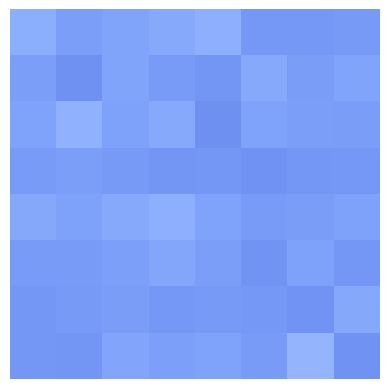

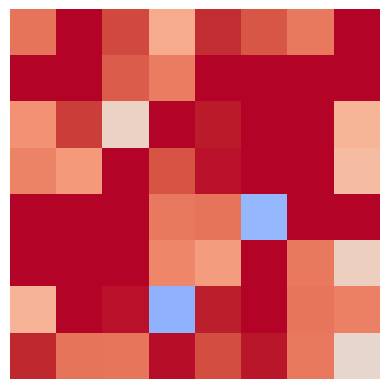

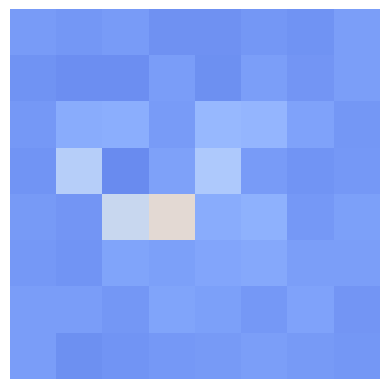

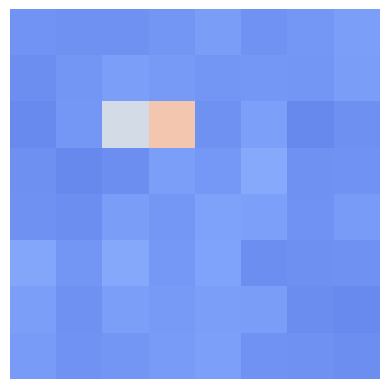

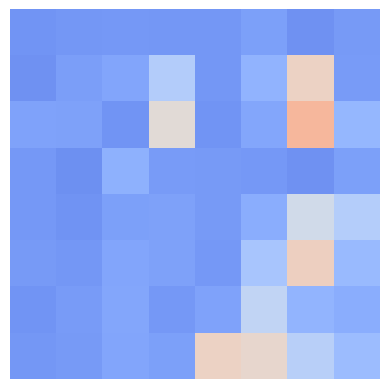

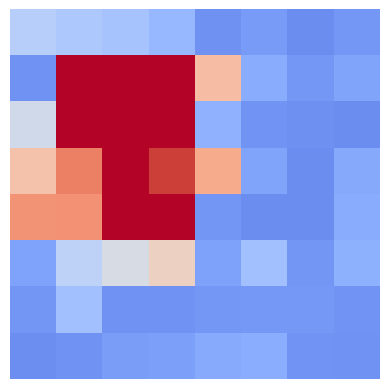

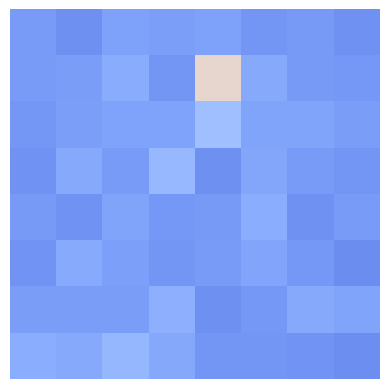

In [32]:


# Reshape data to form a square or near-square matrix
matrix_size_1 = int(np.sqrt(len(heatmap_2_lya_from_APD[0])))

data_matrix_1 = np.array(heatmap_2_lya_from_APD[0][:matrix_size_1**2]).reshape((matrix_size_1, matrix_size_1))
data_matrix_1 = np.flipud(data_matrix_1)

# Determine the min and max values across both datasets for consistent color scaling
#min_value = min(heatmap_2_lya_from_APD)
#max_value = max(heatmap_2_lya_from_APD)
min_value = -0.05
max_value = 0.27

plt.imshow(data_matrix_1, cmap='coolwarm',  aspect='equal', vmin=min_value, vmax=max_value)
#plt.colorbar(label=r'$\lambda$')
#plt.title('Chaosity for point A')
#plt.xlabel(r'$x$')
#plt.ylabel(r'$y$')
#plt.xticks([-0.5, 7.5], [0, 1])
#plt.yticks([-0.5, 7.5], [1, 0])
plt.axis('off')
plt.savefig('heat A.png', dpi=300, bbox_inches='tight')
plt.show()

# Reshape data to form a square or near-square matrix
matrix_size_1 = int(np.sqrt(len(heatmap_2_lya_from_APD[1])))

data_matrix_1 = np.array(heatmap_2_lya_from_APD[1][:matrix_size_1**2]).reshape((matrix_size_1, matrix_size_1))
data_matrix_1 = np.flipud(data_matrix_1)



plt.imshow(data_matrix_1, cmap='coolwarm', aspect='equal', vmin=min_value, vmax=max_value)
#plt.colorbar(label=r'$\lambda$')
#plt.title('Chaosity for point A')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xticks([-0.5, 7.5], [0, 1])
plt.yticks([-0.5, 7.5], [1, 0])
plt.axis('off')
plt.savefig('heat B.png', dpi=300, bbox_inches='tight')
plt.show()

# Reshape data to form a square or near-square matrix
matrix_size_1 = int(np.sqrt(len(heatmap_2_lya_from_APD[2])))

data_matrix_1 = np.array(heatmap_2_lya_from_APD[2][:matrix_size_1**2]).reshape((matrix_size_1, matrix_size_1))
data_matrix_1 = np.flipud(data_matrix_1)


plt.imshow(data_matrix_1, cmap='coolwarm', aspect='equal', vmin=min_value, vmax=max_value)
#plt.colorbar(label=r'$\lambda$')
#plt.title('Chaosity for point A')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xticks([-0.5, 7.5], [0, 1])
plt.yticks([-0.5, 7.5], [1, 0])
plt.axis('off')
plt.savefig('heat C.png', dpi=300, bbox_inches='tight')
plt.show()

# Reshape data to form a square or near-square matrix
matrix_size_1 = int(np.sqrt(len(heatmap_2_lya_from_APD[3])))

data_matrix_1 = np.array(heatmap_2_lya_from_APD[3][:matrix_size_1**2]).reshape((matrix_size_1, matrix_size_1))
data_matrix_1 = np.flipud(data_matrix_1)


plt.imshow(data_matrix_1, cmap='coolwarm', aspect='equal', vmin=min_value, vmax=max_value)
#plt.colorbar(label=r'$\lambda$')
#plt.title('Chaosity for point A')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xticks([-0.5, 7.5], [0, 1])
plt.yticks([-0.5, 7.5], [1, 0])
plt.axis('off')
plt.savefig('heat D.png', dpi=300, bbox_inches='tight')
plt.show()

# Reshape data to form a square or near-square matrix
matrix_size_1 = int(np.sqrt(len(heatmap_2_lya_from_APD[4])))

data_matrix_1 = np.array(heatmap_2_lya_from_APD[4][:matrix_size_1**2]).reshape((matrix_size_1, matrix_size_1))
data_matrix_1 = np.flipud(data_matrix_1)


plt.imshow(data_matrix_1, cmap='coolwarm', aspect='equal', vmin=min_value, vmax=max_value)
#plt.colorbar(label=r'$\lambda$')
#plt.title('Chaosity for point A')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xticks([-0.5, 7.5], [0, 1])
plt.yticks([-0.5, 7.5], [1, 0])
plt.axis('off')
plt.savefig('heat D2.png', dpi=300, bbox_inches='tight')
plt.show()

# Reshape data to form a square or near-square matrix
matrix_size_1 = int(np.sqrt(len(heatmap_2_lya_from_APD[5])))

data_matrix_1 = np.array(heatmap_2_lya_from_APD[5][:matrix_size_1**2]).reshape((matrix_size_1, matrix_size_1))
data_matrix_1 = np.flipud(data_matrix_1)

plt.imshow(data_matrix_1, cmap='coolwarm', aspect='equal', vmin=min_value, vmax=max_value)
#plt.colorbar(label=r'$\lambda$')
#plt.title('Chaosity for point A')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xticks([-0.5, 7.5], [0, 1])
plt.yticks([-0.5, 7.5], [1, 0])
plt.axis('off')
plt.savefig('heat E.png', dpi=300, bbox_inches='tight')
plt.show()

# Reshape data to form a square or near-square matrix
matrix_size_1 = int(np.sqrt(len(heatmap_2_lya_from_APD[6])))

data_matrix_1 = np.array(heatmap_2_lya_from_APD[6][:matrix_size_1**2]).reshape((matrix_size_1, matrix_size_1))
data_matrix_1 = np.flipud(data_matrix_1)

plt.imshow(data_matrix_1, cmap='coolwarm', aspect='equal', vmin=min_value, vmax=max_value)
#plt.colorbar(label=r'$\lambda$')
#plt.title('Chaosity for point A')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.xticks([-0.5, 7.5], [0, 1])
plt.yticks([-0.5, 7.5], [1, 0])
plt.axis('off')
plt.savefig('heat F.png', dpi=300, bbox_inches='tight')
plt.show()

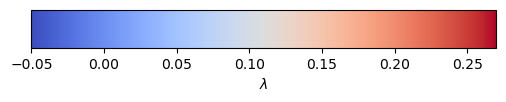

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Dummy figure for colorbar
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
min_value = -0.05
max_value = 0.27
# Create a fake colormap image
cmap = plt.cm.coolwarm
norm = plt.Normalize(vmin=min_value, vmax=max_value)

# Create colorbar
cb = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='horizontal',
    label=r'$\lambda$'
)

# Save only the colorbar
plt.savefig('colorbar_only.png', dpi=300)
plt.show()


In [17]:
            
result_4_lya_from_uvw = []
time = 15000

for repeat_index,repeat in enumerate([1]):
    result_4_lya_from_uvw.append([])
    for regions in range(1):
        result_4_lya_from_uvw[repeat_index].append([])
        for tau_pw_index in range(len(result_2_tau_pw_list)):
            result_4_lya_from_uvw[repeat_index][regions].append([])
            for tau_r_index in range(len(result_2_tau_d_list)):

                V = result_2_uvw_list[tau_pw_index][tau_r_index]
                result = []
                for point in range(0,64):
                    embedded_data = np.zeros([time,3])
                    for i in range(time):
                        for j in range(3):
                            embedded_data[i][j] = (V[j][point][i + regions * time])

                    result.append(wolf_lya_exp(embedded_data,epsilon_uvw,'middle',np.pi / 4,5000))

                result_4_lya_from_uvw[repeat_index][regions][tau_pw_index].append(sum(result)/len(result))

In [18]:
result_uvw = avg_repeat2(result_4_lya_from_uvw)[0]
result_uvw_error_total = avg_repeat2(result_4_lya_from_uvw)[1] 

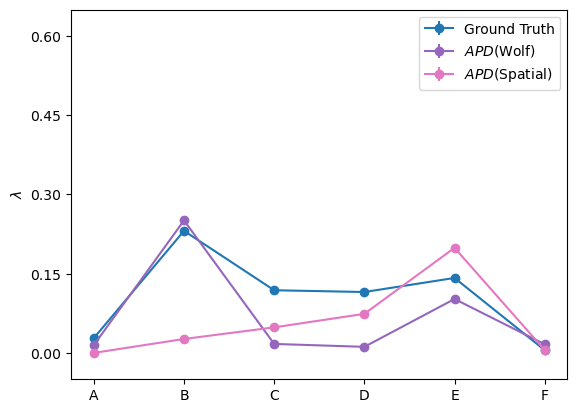

In [47]:
result_uvw = []
result_APD = []
result_APD_spatial = []
for i in range(7):
    if i != 4:
        result_uvw.append(avg_repeat2(result_4_lya_from_uvw)[0][i])
        result_APD.append(avg(result_2_lya_from_APD)[0][i])
        result_APD_spatial.append(avg(result_2_lya_from_APD_spatial)[0][i])


plt.errorbar(['A','B','C','D','E','F'],result_uvw,yerr = [0,0,0,0,0,0], fmt ='-o') 
plt.errorbar(['A','B','C','D','E','F'],result_APD,yerr = [0,0,0,0,0,0], fmt ='-o',color = '#9467bd') 
#plt.errorbar(['A','B','C','D','D1','E','F'],avg(result_2_lya_from_APD_std)[0],yerr = [0,0,0,0,0,0,0], fmt ='--*',color = '#9467bd') 
plt.errorbar(['A','B','C','D','E','F'],result_APD_spatial,yerr = [0,0,0,0,0,0], fmt ='-o',color = '#e377c2') 

plt.ylim(-0.05,0.65)
#plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))  # Max 5 ticks on x-axis
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=5))  # Max 5 ticks on y-axis
plt.legend([r'Ground Truth',r'$APD$(Wolf)',r'$APD$(Spatial)']) #,r'$APD_{std}$(wolf)'
plt.ylabel(r'$\lambda$')
#plt.title(r'Simulations$_{<5 times>}$, cost about 2 days ')

plt.savefig('single spiral LE.png', dpi=300)